In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Euler-Maruyama Scheme:

$$S_{t+\delta t}\sim S_t(1+r\delta t+\sigma\phi\sqrt{\delta t})$$

In [2]:
def simulate_path(s0, mu, sigma, horizon, timesteps, n_sims, seed=None):
    if seed is not None:
        np.random.seed(seed)
    dt = horizon / timesteps
    S = np.zeros((timesteps, n_sims))
    S[0, :] = s0
    for i in range(1, timesteps):
        w = np.random.standard_normal(n_sims)
        S[i, :] = S[i-1, :] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * w)
    return S

Milstein Scheme:

$$S_{t+\delta t}\sim S_t\left(1+r\delta t+\sigma\phi\sqrt{\delta t}+\dfrac{1}{2}\sigma^{2}\left(\phi^2-1\right)\delta t\right)$$


In [3]:
def simulate_path_milstein(s0, mu, sigma, horizon, timesteps, n_sims, seed=None):
    if seed is not None:
        np.random.seed(seed)
    
    dt = horizon / timesteps  # Time step
    S = np.zeros((timesteps, n_sims))  # Initialize stock price matrix
    S[0, :] = s0  # Set initial stock price
    
    for i in range(1, timesteps):
        w = np.random.standard_normal(n_sims)  # Standard normal random variable
        dW = np.sqrt(dt) * w  # Brownian motion increment
        
        # Milstein correction term
        correction = 0.5 * sigma**2 * S[i-1, :] * (dW**2 - dt)
        
        # Apply the Milstein update
        S[i, :] = S[i-1, :] + mu * S[i-1, :] * dt + sigma * S[i-1, :] * dW + correction
    
    return S

Histogram of Simulated Paths

Text(0.5, 1.0, 'Simulated Geometric Brownian Motion at Maturity')

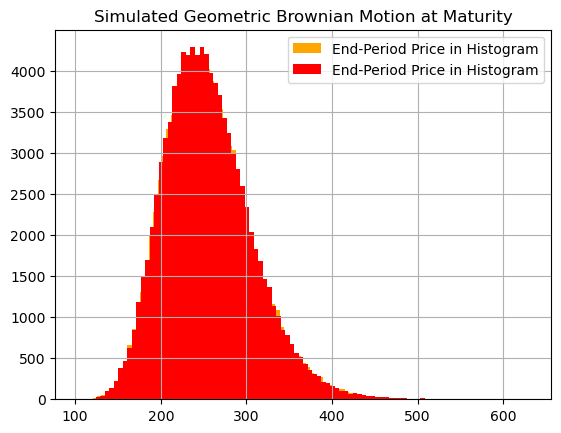

In [4]:
price_path = pd.DataFrame(simulate_path(242.95,0.05,0.2,1,252,100000))
# Plot the histogram of the simulated price path at maturity
price_path.iloc[-1].hist(bins=100, color='orange', label='End-Period Price in Histogram')
plt.legend()
plt.title('Simulated Geometric Brownian Motion at Maturity')

price_path = pd.DataFrame(simulate_path(242.95,0.05,0.2,1,252,100000))
# Plot the histogram of the simulated price path at maturity
price_path.iloc[-1].hist(bins=100, color='red', label='End-Period Price in Histogram')
plt.legend()
plt.title('Simulated Geometric Brownian Motion at Maturity')

Simulate the value of an ACDC (Accumulator/Decumulator) contract using Monte Carlo.

In each period, we compute

$$
X_i = \sum_{j=1}^{n_i} \left[ m \cdot \mathbf{1}\{\delta(s_{i,j} - K) \geq 0\} + G \cdot m \cdot \mathbf{1}\{\delta(s_{i,j} - K) < 0\} \right] \cdot \mathbf{1}(s_{i,j} < B)
$$

and

$$
A_i = \delta (S_i - K)
$$

Then the total present value is given by

$$
PV(t) = \mathbb{E} \left( \sum_{i=1}^{N} X_i A_i \cdot df(t_i, t) \right)
$$

where the discount factor at the settlement date of period \(i\) is defined as

$$
df(t_i, t) = e^{-r t_i}.
$$



In [5]:
def simulate_acdc(S0, r, sigma, T, N_paths, N_periods, days_per_year, m, K, B, G, contract='accumulator', seed=None):
    """
    Simulate the value of an ACDC (Accumulator/Decumulator) contract using Monte Carlo.
    
    For each period, the simulation:
      - Accumulates shares daily based on:
          if delta*(price - B) < 0:
              if delta*(price - K) >= 0: accumulate m shares
              else: accumulate G * m shares
      - At the period's settlement date, calculates the payoff using:
          A_i = delta * (S_settlement - K)
          Payoff_i = (accumulated shares in period) * A_i, discounted to present.
    
    The total payoff is the sum over all periods.
    
    Returns:
        price: float, the estimated price of the ACDC contract.
    """
    n_steps = int(days_per_year * T)  # Total simulation steps; for 1 year, n_steps = 252
    S = simulate_path_milstein(S0, r, sigma, T, n_steps, N_paths, seed)
    delta = 1 if contract.lower() == 'accumulator' else -1
    period_indices = np.linspace(0, n_steps, N_periods + 1, dtype=int)
    period_payoffs = np.zeros((N_paths, N_periods))
    
    for i in range(N_periods):
        start_index = period_indices[i]
        # For the final period, use the full period so that t_settlement = n_steps/days_per_year
        if i == N_periods - 1:
            settlement_index = n_steps - 1  # Last index of S (i.e., day 251, which represents 252 days)
            t_settlement = n_steps / days_per_year  # t_settlement = 252/252 = 1 year
            S_settlement = S[settlement_index, :]
        else:
            settlement_index = period_indices[i + 1] - 1
            t_settlement = (settlement_index + 1) / days_per_year  # +1 to count days correctly
            S_settlement = S[settlement_index, :]
        
        X_i = np.zeros(N_paths)
        days_in_period = settlement_index - start_index + 1
        
        for day in range(days_in_period):
            for sim in range(N_paths):
                price = S[start_index + day, sim]
                if delta * (price - B) < 0:
                    if delta * (price - K) >= 0:
                        X_i[sim] += m  
                    else:
                        X_i[sim] += G * m  
                else:
                    X_i[sim] += 0
        
        A_i = delta * (S_settlement - K)
        period_payoff = X_i * A_i
        discount_factor = np.exp(-r * t_settlement)
        period_payoffs[:, i] = period_payoff * discount_factor
        
        # Print discount factor and the average discounted payoff for this period
        avg_payoff = np.mean(period_payoffs[:, i])
        print(f"Period {i+1}: t_settlement = {t_settlement*days_per_year:.3f} days, discount_factor = {discount_factor:.9f}, avg discounted payoff = {avg_payoff:.4f}")
    
    total_payoffs = np.sum(period_payoffs, axis=1)
    price = np.mean(total_payoffs)
    return price

In [11]:
if __name__ == '__main__':

    S0 = 214.945         # initial stock price
    r = 0.05842          # risk-free rate (annualized).
    sigma = 0.0          # volatility (annualized).
    T = 12/12            # time to expiry in years.
    days_per_year = 252  # number of trading days per year.
    N_periods = 12       # number of settlement periods (e.g., 12 for monthly).
    N_paths = 10000      # number of Monte Carlo simulation paths. 
    m = 1.0              # number of shares accumulated per eligible day.
    K = 214.945          # strike price.
    #B = 216.062714      # auto-call.
    B = 500.0            # knock-out barrier.
    G = 1                # gearing factor. 
    contract_type = 'accumulator' # choose either 'accumulator' or 'decumulator' (sets the sign).
    seed = 100 #int or None, seed for reproducibility.
    
    price = simulate_acdc(S0, r, sigma, T, N_paths, N_periods, days_per_year, m, K, B, G, contract=contract_type, seed=seed)
    print(f"Estimated price of the {contract_type} ACDC contract: {price:.4f}")


Period 1: t_settlement = 21.000 days, discount_factor = 0.995143498, avg discounted payoff = 20.8728
Period 2: t_settlement = 42.000 days, discount_factor = 0.990310581, avg discounted payoff = 42.6853
Period 3: t_settlement = 63.000 days, discount_factor = 0.985501136, avg discounted payoff = 64.3918
Period 4: t_settlement = 84.000 days, discount_factor = 0.980715047, avg discounted payoff = 85.9929
Period 5: t_settlement = 105.000 days, discount_factor = 0.975952202, avg discounted payoff = 107.4891
Period 6: t_settlement = 126.000 days, discount_factor = 0.971212488, avg discounted payoff = 128.8809
Period 7: t_settlement = 147.000 days, discount_factor = 0.966495793, avg discounted payoff = 150.1688
Period 8: t_settlement = 168.000 days, discount_factor = 0.961802004, avg discounted payoff = 171.3533
Period 9: t_settlement = 189.000 days, discount_factor = 0.957131010, avg discounted payoff = 192.4349
Period 10: t_settlement = 210.000 days, discount_factor = 0.952482701, avg discou